# A Deep Learning Framework for Diagnosis of Pneumonia, COVID-19, and Tuberculosis

# 1. Data Preparation

### importing Packages

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from pathlib import Path
from glob import glob
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import cv2 

import warnings
warnings.filterwarnings('ignore')

### Check for GPU

In [4]:
# checking for GPU 

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.test.gpu_device_name())

Num GPUs Available:  1
/device:GPU:0


### Importing the data

In [5]:
import pathlib
data_dir = "main_dataset/"
data_dir = pathlib.Path(data_dir)

In [6]:
image_count = len(list(data_dir.glob('*/*.*')))

print(image_count)

21473


### Train and test split

In [7]:
batch_size = 32
img_height = 300
img_width = 300

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    label_mode='categorical',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 21473 files belonging to 4 classes.
Using 17179 files for training.


In [8]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    label_mode='categorical',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 21473 files belonging to 4 classes.
Using 4294 files for validation.


In [9]:
class_names = train_ds.class_names
print(class_names)

['COVID-19', 'NO-FINDINGS', 'PNEUMONIA', 'TUBERCULOSIS']


# 2. Exploratory Data Analysis (EDA)

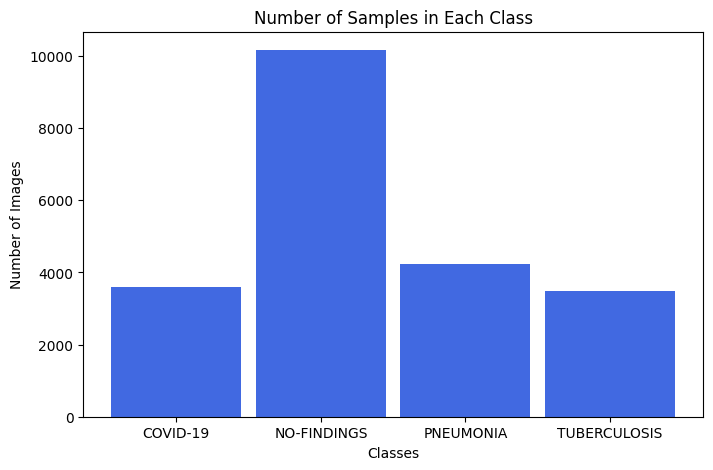

In [10]:
# get the count of all images inside each class
covid_count = len(list(data_dir.glob('COVID-19/*.*')))
no_findings_count = len(list(data_dir.glob('NO-FINDINGS/*.*')))
pneumonia_count = len(list(data_dir.glob('PNEUMONIA/*.*')))
tb_count = len(list(data_dir.glob('TUBERCULOSIS/*.*')))

data = {'COVID-19':covid_count, 'NO-FINDINGS':no_findings_count, 'PNEUMONIA':pneumonia_count,'TUBERCULOSIS':tb_count}
classes = list(data.keys())
values = list(data.values())

fig = plt.figure(figsize = (8, 5))
# creating the bar plot
plt.bar(classes, values, color ='royalblue', width = 0.9)
plt.xlabel("Classes")
plt.ylabel("Number of Images")
plt.title("Number of Samples in Each Class")
plt.show()

In [11]:
import pandas as pd    
    
dict= { 'No. of Samples':[covid_count,no_findings_count,pneumonia_count,tb_count]}    
    
df=pd.DataFrame(dict,index=['COVID-19','NO-FINDINGS','PNEUMONIA','TUBERCULOSIS'])    
df

,No. of Samples
COVID-19,3591
NO-FINDINGS,10167
PNEUMONIA,4240
TUBERCULOSIS,3475


### Plotting function

In [12]:
import os
import random
from PIL import Image

def plot(directory, title) : 
    # get the list of image file names in the directory
    image_files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.jpeg') or f.endswith('.png')]
    # randomly select 36 images
    random_images = random.sample(image_files, 36)
    # create figure with 6x6 grid of subplots
    fig, axs = plt.subplots(6, 6, figsize=(12, 12))
    # loop through subplots and display each image with RGB colors
    for i in range(6):
        for j in range(6):
            # open image
            img = Image.open(random_images[i*6+j])
            # convert to RGB if necessary (without this piece of code the images will plot with a yellow tint)
            if img.mode != 'RGB':
                img = img.convert('RGB')

            # display image in subplot
            axs[i, j].imshow(img)
            axs[i, j].set_title(title)
            axs[i, j].axis('off')

    # show plot
    plt.show()

### COVID-19 Samples

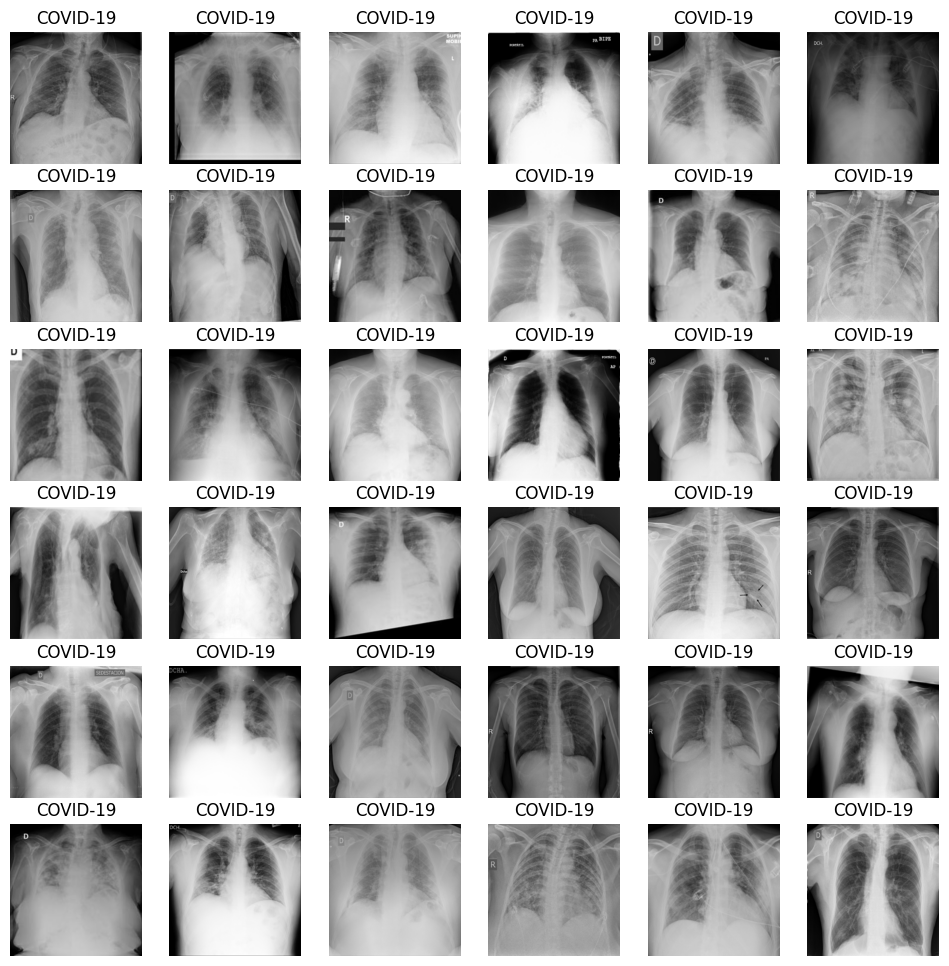

In [13]:
covid_directory = "main_dataset/COVID-19/"
covid_title = "COVID-19" 

plot(covid_directory, covid_title)

### NO-FINDINGS Samples

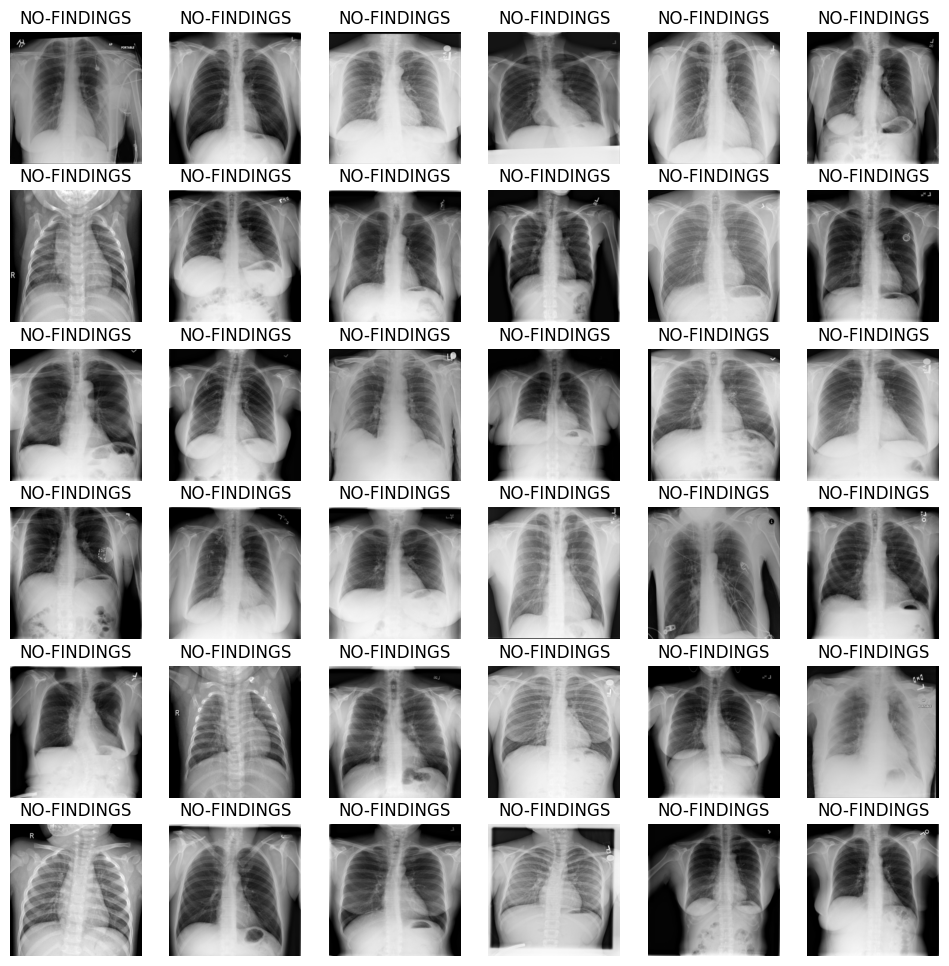

In [14]:
no_findings_directory = "main_dataset/NO-FINDINGS/"
no_findings_title = "NO-FINDINGS" 

plot(no_findings_directory, no_findings_title)

### PNEUMONIA Samples

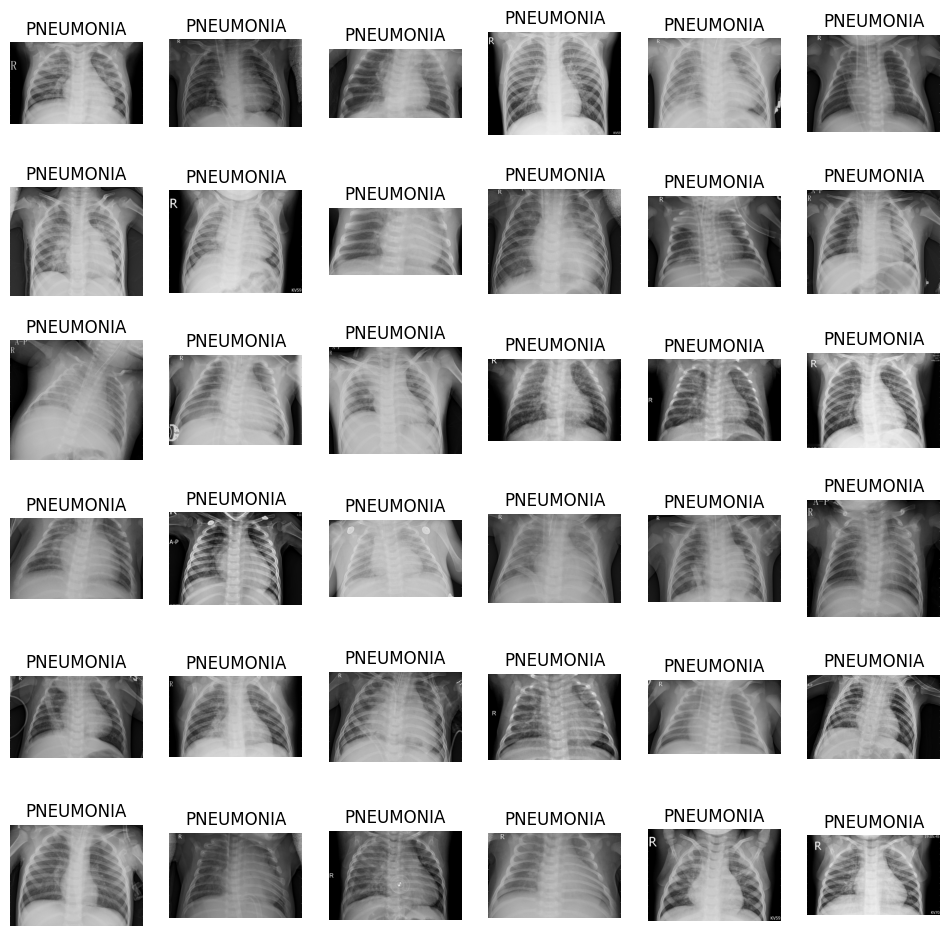

In [15]:
pneumonia_directory = "main_dataset/PNEUMONIA/"
pneumonia_title = "PNEUMONIA" 

plot(pneumonia_directory, pneumonia_title)

### TUBERCULOSIS Samples

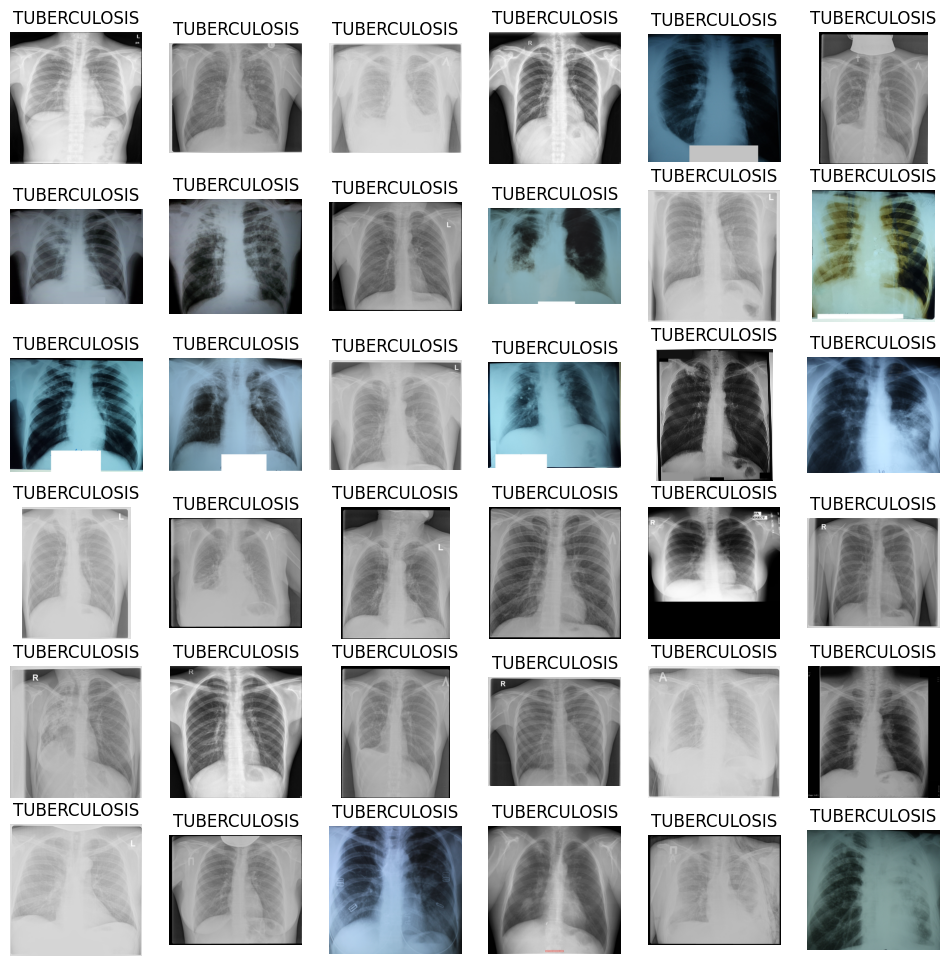

In [16]:
tuberculosis_directory = "main_dataset/TUBERCULOSIS/"
tuberculosis_title = "TUBERCULOSIS" 

plot(tuberculosis_directory, tuberculosis_title)

# 3. Model Building

In [17]:
num_classes = len(class_names)
tf.random.set_seed(42)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(256, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.9),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes,activation='softmax')
])

In [18]:
model.compile(optimizer='adam',loss='categorical_crossentropy' , metrics=['accuracy'])

In [19]:
# Stops the training if the validation accuracy doesn't improve for 10 consecutive epochs 
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10)
# Reduce the learning rate when the validation accuracy stagnates for 3 consecutive epochs 
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', 
                              factor = 0.5, 
                              patience = 3, 
                              min_delta = 0.001,
                              mode='auto',verbose=1)

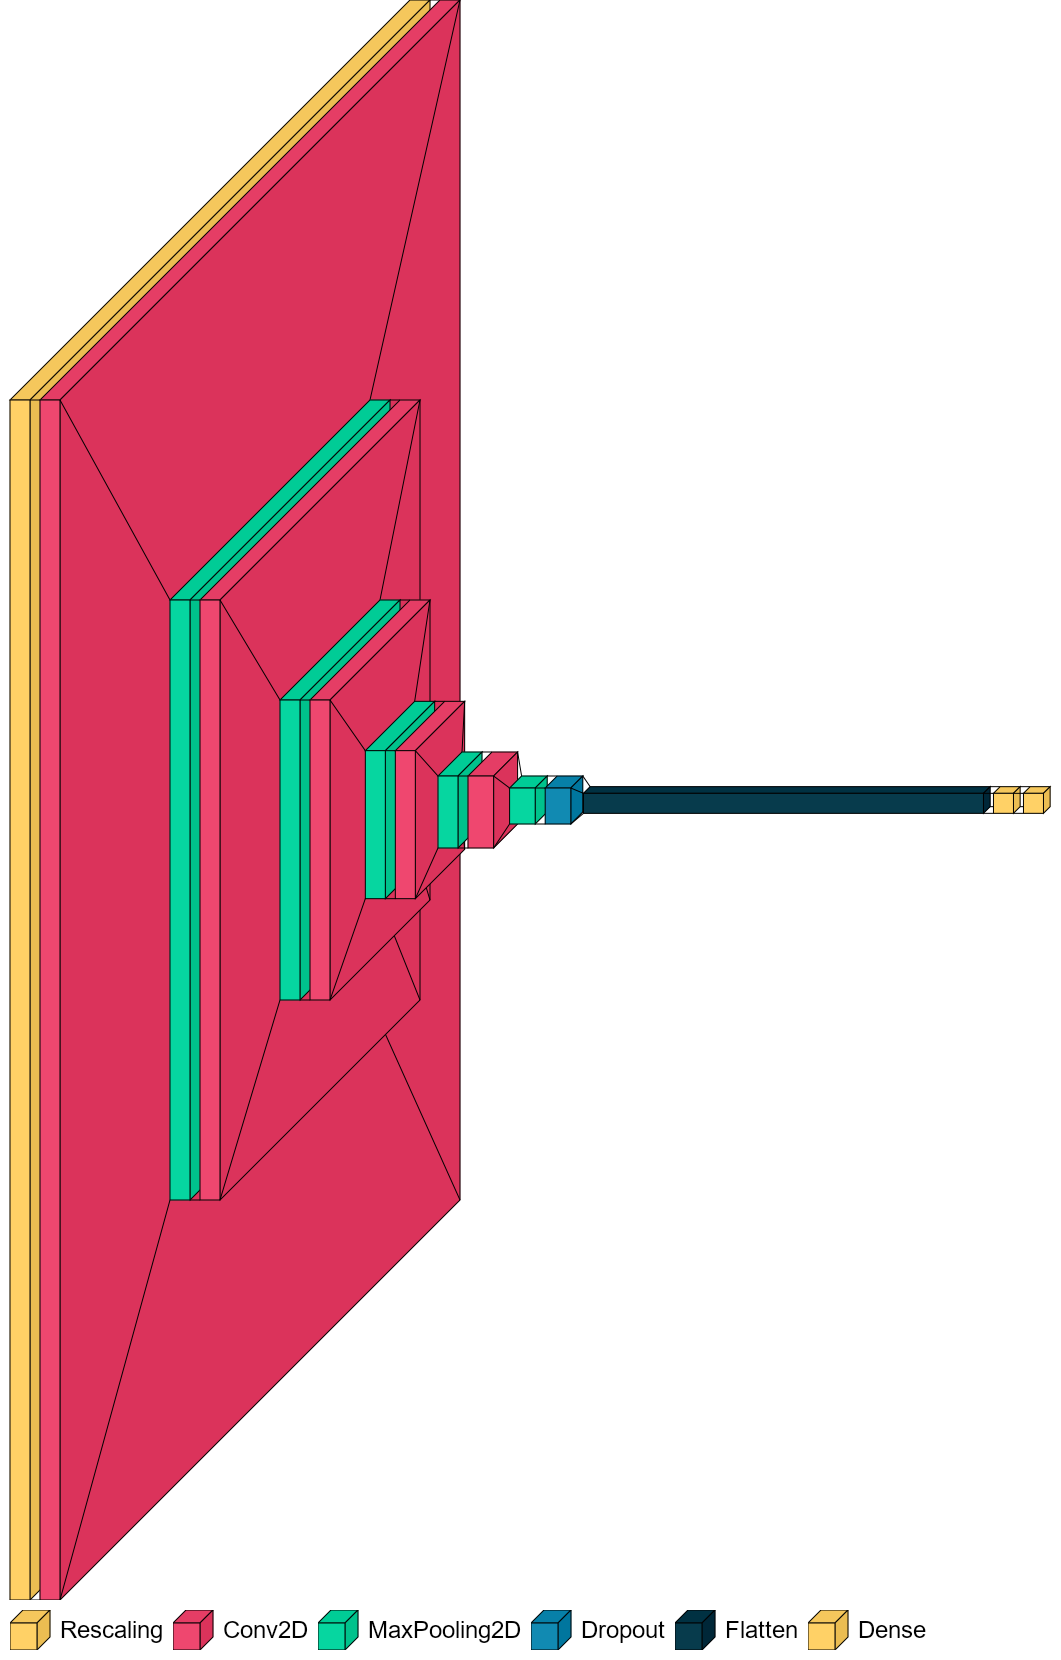

In [28]:
from PIL import ImageFont
import visualkeras

font = ImageFont.truetype("arial.ttf", 24) 
visualkeras.layered_view(model, legend=True, font=font) 

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 300, 300, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 300, 300, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 150, 150, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 150, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 37, 37, 64)        0

# 4. Model Training

In [16]:
epochs=50
hist = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[reduce_lr, callback]
)

Epoch 1/50
537/537 [==============================] - 39s 62ms/step - loss: 0.5865 - accuracy: 0.7649 - val_loss: 0.2922 - val_accuracy: 0.8959
Epoch 2/50
537/537 [==============================] - 32s 59ms/step - loss: 0.3380 - accuracy: 0.8740 - val_loss: 0.2193 - val_accuracy: 0.9252
Epoch 3/50
537/537 [==============================] - 31s 58ms/step - loss: 0.2489 - accuracy: 0.9090 - val_loss: 0.1642 - val_accuracy: 0.9453
Epoch 4/50
537/537 [==============================] - 31s 57ms/step - loss: 0.2092 - accuracy: 0.9217 - val_loss: 0.1399 - val_accuracy: 0.9544
Epoch 5/50
537/537 [==============================] - 31s 57ms/step - loss: 0.1714 - accuracy: 0.9398 - val_loss: 0.1172 - val_accuracy: 0.9620
Epoch 6/50
537/537 [==============================] - 33s 62ms/step - loss: 0.1469 - accuracy: 0.9464 - val_loss: 0.1284 - val_accuracy: 0.9581
Epoch 7/50
537/537 [==============================] - 32s 59ms/step - loss: 0.1467 - accuracy: 0.9485 - val_loss: 0.1026 - val_accuracy:

# 5. Model Evaluation

### Saving and Loading The Model

In [22]:
model.save('GP-Multiclass.h5')

In [23]:
loaded_model = tf.keras.models.load_model("GP-Multiclass.h5")

### Saving and loading the model's history

In [24]:
import pickle

# save model's history
with open('trainHistoryDict', 'wb') as file_pi:
    pickle.dump(hist.history, file_pi)

In [25]:
import pickle

# load model's history
with open('trainHistoryDict', "rb") as file_pi:
    history = pickle.load(file_pi)

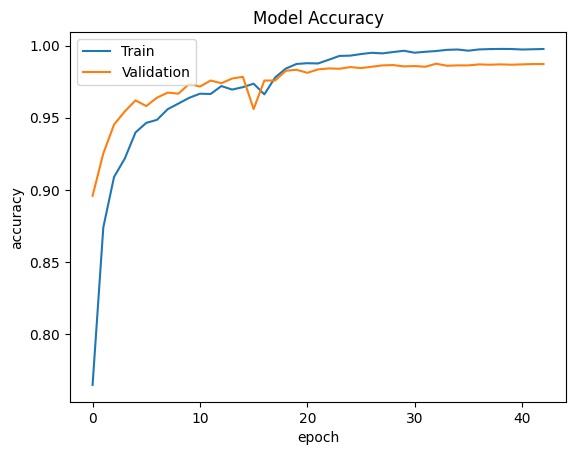

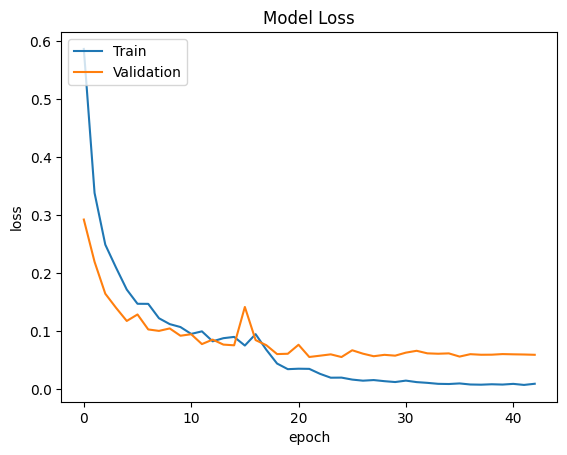

In [26]:
# Plot the history for accuracy 
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# Plot the history for loss 
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [27]:
# EVALUATE TRAINING ACCURACY
results = loaded_model.evaluate(train_ds)

537/537 [==============================] - 18s 30ms/step - loss: 9.4780e-04 - accuracy: 0.9998


In [36]:
# EVALUATE VALIDATION ACCURACY
results = loaded_model.evaluate(val_ds)

135/135 [==============================] - 5s 34ms/step - loss: 0.0589 - accuracy: 0.9872


# Inference Stage

In [56]:
from os import listdir
from cv2 import imread

### Prediction function

In [57]:
def predict(img_path):  
    img_name = os.path.basename(img_path)
    img = tf.keras.utils.load_img(img_path, target_size=(img_height, img_width))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    predictions = loaded_model.predict(img_array)
    score = predictions[0]
    res = "{}\t most likely belongs to {} with a {:.2f} percent confidence."\
    .format((img_name), class_names[np.argmax(score)], 100 * np.max(score))
    print(res)

### Looping through inference directory function

In [58]:
def loop_dir(directory) : 
    for images in os.listdir(directory):
        if (images.endswith(".png")) or images.endswith(".jpeg") :
            img = imread(images)
            img_path = (directory+images)
            predict(img_path)

### Covid-19 Inference

In [59]:
covid_dir = "Demo_Val_img/COVID-19/"
loop_dir(covid_dir)

COVID-110.png	 most likely belongs to COVID-19 with a 100.00 percent confidence.
COVID-1305.png	 most likely belongs to NO-FINDINGS with a 99.59 percent confidence.
COVID-1333.png	 most likely belongs to COVID-19 with a 100.00 percent confidence.
COVID-22.png	 most likely belongs to NO-FINDINGS with a 94.50 percent confidence.
COVID-26.png	 most likely belongs to COVID-19 with a 100.00 percent confidence.
COVID-3.png	 most likely belongs to COVID-19 with a 99.89 percent confidence.
COVID-30.png	 most likely belongs to COVID-19 with a 100.00 percent confidence.
COVID-32.png	 most likely belongs to COVID-19 with a 94.45 percent confidence.
COVID-332.png	 most likely belongs to COVID-19 with a 100.00 percent confidence.
COVID-340.png	 most likely belongs to NO-FINDINGS with a 98.79 percent confidence.
COVID-345.png	 most likely belongs to COVID-19 with a 94.41 percent confidence.
COVID-349.png	 most likely belongs to COVID-19 with a 100.00 percent confidence.
COVID-38.png	 most likely bel

### No-Findings Inference

In [60]:
no_findings_dir = "Demo_Val_img/NO_FINDINGS/"
loop_dir(no_findings_dir)

Normal-1018.png	 most likely belongs to NO-FINDINGS with a 100.00 percent confidence.
Normal-1024.png	 most likely belongs to NO-FINDINGS with a 100.00 percent confidence.
Normal-110.png	 most likely belongs to NO-FINDINGS with a 98.65 percent confidence.
Normal-1164.png	 most likely belongs to NO-FINDINGS with a 100.00 percent confidence.
Normal-1181.png	 most likely belongs to NO-FINDINGS with a 100.00 percent confidence.
Normal-127.png	 most likely belongs to NO-FINDINGS with a 100.00 percent confidence.
Normal-129.png	 most likely belongs to NO-FINDINGS with a 100.00 percent confidence.
Normal-1306.png	 most likely belongs to NO-FINDINGS with a 100.00 percent confidence.
Normal-1323.png	 most likely belongs to NO-FINDINGS with a 100.00 percent confidence.
Normal-1330.png	 most likely belongs to NO-FINDINGS with a 100.00 percent confidence.
Normal-138.png	 most likely belongs to NO-FINDINGS with a 100.00 percent confidence.
Normal-1610.png	 most likely belongs to NO-FINDINGS with a 

### Pneumonia Inference

In [61]:
pneumonia_dir = "Demo_Val_img/PNEUMONIA/"
loop_dir(pneumonia_dir)

person100_bacteria_480.jpeg	 most likely belongs to PNEUMONIA with a 100.00 percent confidence.
person126_bacteria_598.jpeg	 most likely belongs to PNEUMONIA with a 100.00 percent confidence.
person127_bacteria_602.jpeg	 most likely belongs to PNEUMONIA with a 100.00 percent confidence.
person133_bacteria_638.jpeg	 most likely belongs to PNEUMONIA with a 100.00 percent confidence.
person1420_virus_2431.jpeg	 most likely belongs to PNEUMONIA with a 100.00 percent confidence.
person1946_bacteria_4874.jpeg	 most likely belongs to PNEUMONIA with a 100.00 percent confidence.
person1946_bacteria_4875.jpeg	 most likely belongs to PNEUMONIA with a 100.00 percent confidence.
person1947_bacteria_4876.jpeg	 most likely belongs to PNEUMONIA with a 100.00 percent confidence.
person1949_bacteria_4880.jpeg	 most likely belongs to PNEUMONIA with a 100.00 percent confidence.
person1950_bacteria_4881.jpeg	 most likely belongs to PNEUMONIA with a 100.00 percent confidence.
person1952_bacteria_4883.jpeg	 

### Tuberculosis Inference

In [62]:
tb_dir = "Demo_Val_img/TUBERCULOSIS/"
loop_dir(tb_dir)

TB (1058).png	 most likely belongs to TUBERCULOSIS with a 100.00 percent confidence.
TB (12).png	 most likely belongs to TUBERCULOSIS with a 100.00 percent confidence.
TB (1233).png	 most likely belongs to TUBERCULOSIS with a 100.00 percent confidence.
TB (1369).png	 most likely belongs to TUBERCULOSIS with a 100.00 percent confidence.
TB (1389).png	 most likely belongs to TUBERCULOSIS with a 100.00 percent confidence.
TB (1542).png	 most likely belongs to TUBERCULOSIS with a 100.00 percent confidence.
TB (1546).png	 most likely belongs to TUBERCULOSIS with a 100.00 percent confidence.
TB (1719).png	 most likely belongs to TUBERCULOSIS with a 100.00 percent confidence.
TB (1728).png	 most likely belongs to TUBERCULOSIS with a 100.00 percent confidence.
TB (1843).png	 most likely belongs to TUBERCULOSIS with a 100.00 percent confidence.
TB (1849).png	 most likely belongs to TUBERCULOSIS with a 100.00 percent confidence.
TB (1995).png	 most likely belongs to TUBERCULOSIS with a 100.00 pe

# Classification Report

In [63]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [64]:
prediction_classes = np.array([])
true_classes =  np.array([])

for x, y in val_ds:
  prediction_classes = np.concatenate([prediction_classes,
                       np.argmax(loaded_model.predict(x), axis = -1)])
  true_classes = np.concatenate([true_classes, np.argmax(y.numpy(), axis=-1)])

In [65]:
print(classification_report(true_classes, prediction_classes, target_names=class_names, digits=4))

              precision    recall  f1-score   support

    COVID-19     0.9700    0.9627    0.9663       671
 NO-FINDINGS     0.9872    0.9935    0.9904      2015
   PNEUMONIA     0.9989    0.9966    0.9977       872
TUBERCULOSIS     0.9890    0.9810    0.9850       736

    accuracy                         0.9872      4294
   macro avg     0.9863    0.9835    0.9848      4294
weighted avg     0.9872    0.9872    0.9872      4294



# Confusion Matrix

In [66]:
cm = confusion_matrix(true_classes, prediction_classes)
print(cm)

[[ 646   21    0    4]
 [   9 2002    0    4]
 [   0    3  869    0]
 [  11    2    1  722]]


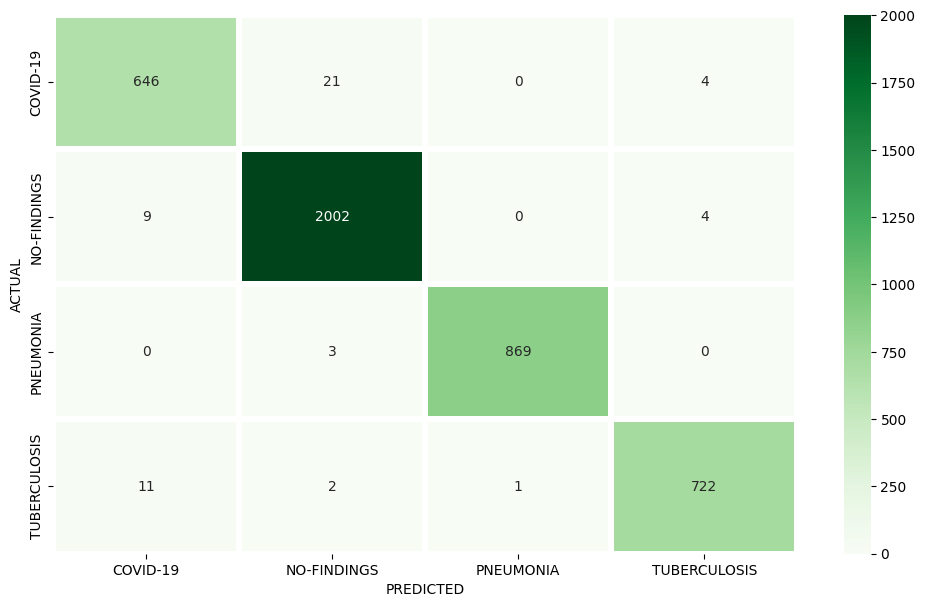

In [67]:
fig,ax=plt.subplots(1,1,figsize=(12,7))
cm = confusion_matrix(true_classes, prediction_classes)

sns.heatmap(cm,cmap="Greens", annot=True,xticklabels=class_names, yticklabels=class_names ,linewidths=3 ,fmt='g')
plt.xlabel("PREDICTED")
plt.ylabel("ACTUAL")
plt.show()